In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import os
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.layers.python.layers import utils

import resnet_v2 as resnet
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


In [2]:
def keypoint_CrossEntropyLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction_maps,labels=keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

In [3]:
def keypoint_SquaredErrorLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.squared_difference(prediction_maps,keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

# Initialize Dataset

In [4]:
def get_data(base_dir,image_dir,ann_file):
    image_path = '{}/images/{}'.format(baseDir,image_dir)
    ann_path='{}/annotations/{}.json'.format(baseDir,ann_file)

    return image_path, ann_path
    
# define the path to the annotation file corresponding to the images you want to work with
baseDir='/Users/kyle/Repositories/coco'

trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

imageTrainDir = 'train2014'
imageValDir = 'val2014'
imageTestDir = 'test2015'

train_img_path, train_ann_path = get_data(baseDir,imageTrainDir,trainData)
val_img_path, val_ann_path = get_data(baseDir,imageValDir,valData)

# initialize a coco object
coco = COCO(train_ann_path)

# get all images containing the 'person' category
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

# Just for dealing with the images on my computer (not necessary when working with the whole dataset)
catIds = imgIds[0:30]
imgIds = imgIds[0:30]
    

loading annotations into memory...
Done (t=10.03s)
creating index...
index created!


In [ ]:
graph = tf.Graph()
with graph.as_default():
    
    VGG_MEAN = tf.reshape(tf.constant([123.68, 116.78, 103.94]),[1,1,3])
    NUM_KEYPOINTS = 17
    BATCH_SIZE = 10
    L = 10.0 # keypoint effective radius
    
    def extract_annotations(filename, imgID, coco=coco):
        anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
        ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
        bbox = np.array(np.floor(ann['bbox']),dtype=int)
        keypoints = np.reshape(ann['keypoints'],(-1,3))
        mask = coco.annToMask(ann)
        
        return filename, bbox, keypoints, mask
    
    def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D = tf.constant(256.0)):
        """
        Returns:
        resized_image (N,D,D,3) - cropped, padded (if needed), scaled to square image of size D
        resized_mask (N,D,D,1) - cropped, padded (if needed), scaled to square mask of size D
        pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
        labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
        """
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.cast(image_decoded, tf.float32)

        mask = tf.transpose([mask],[1,2,0])
        bbox_tensor = tf.to_float(bbox_tensor)
        keypoints_tensor = tf.to_float(keypoints_tensor)

        sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
        centerY = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
        centerX = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
        center = tf.stack([centerY,centerX])

        corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                             tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
        corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                             tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
        i_shape = tf.subtract(corner2,corner1)
        d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

        scale = tf.divide(D, sideLength)
        cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                      tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
        cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                      tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

        dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
        dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

        pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
        pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
        pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
        pts = tf.multiply(pts,scale) # scale keypoints

        # set invalid pts to 0
        inbounds = tf.less(pts,D)
        inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
        pts = tf.multiply(pts,tf.to_float(inbounds))
        pts = tf.transpose(pts,[1,0])
        labels = tf.transpose(labels,[1,0])

        padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                    tf.to_int32(sideLength),tf.to_int32(sideLength))
        padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                    tf.to_int32(sideLength),tf.to_int32(sideLength))

        resized_image = tf.image.resize_images(padded_image,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        resized_image = resized_image - VGG_MEAN
        resized_mask = tf.image.resize_images(padded_mask,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return resized_image, resized_mask, pts, labels

    def scaleDownMaskAndKeypoints(image, mask, pts, labels):
        mask = tf.image.resize_images(mask,tf.constant([128,128]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        pts = tf.multiply(pts,tf.constant(0.5))
        return image, mask, pts, labels
    
    def generate_keypoint_masks(image, mask, keypoints, labels, D=128.0, L=L):
        X, Y = tf.meshgrid(tf.linspace(0.0,128.0,128),tf.linspace(0.0,128.0,128))
        X = tf.reshape(X,[128,128,1])
        Y = tf.reshape(Y,[128,128,1])
        X_stack = tf.tile(X,tf.constant([1,1,17],dtype=tf.int32))
        Y_stack = tf.tile(Y,tf.constant([1,1,17],dtype=tf.int32))

        pts = tf.reshape(keypoints,[1,2,17])
        ptsX, ptsY = tf.split(pts,[1,1],axis=1)
        d1 = tf.square(tf.subtract(X_stack,ptsX))
        d2 = tf.square(tf.subtract(Y_stack,ptsY))

        pt_masks = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)
        return image, mask, pt_masks, pts, labels
    
    ########## DATASET ###########
    
    with tf.variable_scope("DataSet"):
        # Initialize train_dataset
        filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path,imgID) for imgID in imgIds])
        imgID_tensor = tf.constant(imgIds)

        train_dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))
        # Extract Annotations via coco interface
        train_dataset = train_dataset.map(lambda filename, imgID: tf.py_func(extract_annotations, [filename, imgID], 
                                                                     [filename.dtype, tf.int64, tf.int64, tf.uint8]))
        # All other preprocessing in tensorflow
        train_dataset = train_dataset.map(preprocess_image_tf)
        train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)
        train_dataset = train_dataset.map(generate_keypoint_masks)

        # BATCH
        train_dataset = train_dataset.shuffle(buffer_size=10000)
        train_dataset = train_dataset.batch(10) # must resize images to make them match
        iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
        # resized_image, resized_mask, pts, labels = iterator.get_next()
#         images, masks, pts, labels = iterator.get_next()
        images, masks, kpt_masks, pts, labels = iterator.get_next()
        train_init_op = iterator.make_initializer(train_dataset)
        
    
    ##################################################################
    ##################### BACKBONE ARCHITECTURE ######################
    ##################################################################
    
    resnet_v2 = tf.contrib.slim.nets.resnet_v2
    with slim.arg_scope(resnet_v2.resnet_arg_scope()):
        logits, endpoints = resnet_v2.resnet_v2_50(
            inputs=images,
            num_classes=10,
            is_training=is_training,
            reuse=None,
            output_stride=16,
            scope='resnet_v2_50'
            )

        model_path = 'checkpoints/resnet_v2_50.ckpt'
        assert(os.path.isfile(model_path))
        # Backbone Variables - remember to exclude all variables above backbone (including block4 and logits)
        variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['resnet_v2_50/postnorm','resnet_v2_50/logits'])
        # Head variables
        # Note: We would need another set of variables and another initializer to capture the logits as well
        other_variables = tf.contrib.framework.get_variables('resnet_v2_50/postnorm')

    
    ##################################################################
    ####################### HEAD ARCHITECTURE ########################
    ##################################################################
    
    HEAD_SCOPE = 'NetworkHead'
    PREDICTION_THRESHOLD = 0.5

    with tf.variable_scope(HEAD_SCOPE):
        block1 = endpoints['resnet_v2_50/block1']
        block2 = endpoints['resnet_v2_50/block2']
        block3 = endpoints['resnet_v2_50/block3']
        block4 = endpoints['resnet_v2_50/block4']

        with tf.variable_scope('Layer1'):
            b1 = tf.layers.conv2d(block1, 64, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)
            b2 = tf.layers.conv2d(block2, 128, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)
            b3 = tf.layers.conv2d(block3, 128, kernel_size=(1,1), strides=(1,1),padding='SAME',activation=tf.nn.relu)
            b4 = tf.layers.conv2d(block4, 128, kernel_size=(1,1), strides=(1,1),padding='SAME',activation=tf.nn.relu)

        with tf.variable_scope('Layer2'):
            b1 = tf.layers.conv2d(block1, 32, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)

            b2 = tf.layers.conv2d_transpose(b2, 32, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)
            b3 = tf.layers.conv2d_transpose(b3, 64, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)
            b4 = tf.layers.conv2d_transpose(b4, 64, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)

            b2 = tf.slice(b2,[0,1,1,0],b2.shape - np.array([0, 2, 2, 0]))
            b3 = tf.slice(b3,[0,1,1,0],b3.shape - np.array([0, 2, 2, 0]))
            b4 = tf.slice(b4,[0,1,1,0],b4.shape - np.array([0, 2, 2, 0]))

        with tf.variable_scope('BatchNorm'):
            b1 = tf.layers.batch_normalization(b1)
            b2 = tf.layers.batch_normalization(b2)
            b3 = tf.layers.batch_normalization(b3)
            b4 = tf.layers.batch_normalization(b4)

        with tf.variable_scope('Funnel'):
            head = tf.concat([b1,b2,b3,b4],axis=3)

        with tf.variable_scope('MaskHead'):
            mask_head = tf.layers.conv2d_transpose(head, 16, (3,3), (2,2), padding='VALID', activation=tf.nn.relu)
            mask_head = tf.slice(mask_head,[0,1,1,0],mask_head.shape - np.array([0, 2, 2, 0]))
            mask_head = tf.layers.conv2d(mask_head, 1, (1,1), (1,1), padding='SAME', activation=None)

        with tf.variable_scope('KeypointHead'):
            keypoint_head = tf.layers.conv2d_transpose(head, 32, (3,3), (2,2), padding='VALID', activation = tf.nn.relu)
            keypoint_head = tf.slice(keypoint_head,[0,1,1,0],keypoint_head.shape - np.array([0, 2, 2, 0]))
            keypoint_head = tf.layers.conv2d(keypoint_head, 17, (1,1), (1,1), padding='SAME', activation=None)

        with tf.variable_scope('MaskPrediction'):
            mask_prediction = tf.nn.sigmoid(mask_head)
            mask_prediction = tf.to_float(tf.greater_equal(mask_prediction, PREDICTION_THRESHOLD))

        with tf.variable_scope('KeypointsPrediction'):
            keypoint_prediction = tf.nn.sigmoid(keypoint_head)
            keypoint_prediction = tf.to_float(tf.greater_equal(keypoint_prediction, PREDICTION_THRESHOLD))

            
            
    with tf.Session(graph=graph) as sess:
        file_writer = tf.summary.FileWriter('/tmp/HourGlassNet/1')
        file_writer.add_graph(sess.graph)
        
        # initialize variables
        sess.run(tf.global_variables_initializer())
        
        # initialize dataset
        sess.run(train_init_op) 
        masks, kpt_masks, mask_pred, kpt_pred, mask_loss, kpt_loss = sess.run([masks, kpt_masks, maskPrediction, 
                                                             keypointPredictions, maskLoss, keypointLoss])

print("done")

In [ ]:
i = 3
plt.subplot(2,2,1)
plt.imshow(mask_pred[i][:,:,0])
plt.subplot(2,2,2)
plt.imshow(kpt_pred[i][:,:,0])

plt.subplot(2,2,3)
plt.imshow(masks[i][:,:,0])
plt.subplot(2,2,4)
plt.imshow(np.sum(kpt_masks[i],axis=2))

In [ ]:
sess = tf.Session()
init_fn(sess)  # load the pretrained weights
# sess.run(fc8_init)  # initialize the new fc8 layer
sess.run(train_init_op)

In [ ]:
# resized_image, resized_mask, pts, labels = sess.run(next_element)

try:
    I, M, P, L = sess.run([images, masks, pts, labels], {is_training: True})
    plt.imshow(I[0])
    plt.imshow(M[0][:,:,0],alpha=0.5)
    plt.scatter(P[0][(np.reshape(L[0],-1)==2),0],P[0][(np.reshape(L[0],-1)==2),1],c="r")
except tf.errors.OutOfRangeError:
    sess.run(train_init_op)
    print("Reinitialized Dataset Iterator...")
    

### Playing around with ResNet V2 50

In [ ]:
BATCH_SIZE = 10
D = 225
images = tf.placeholder(tf.float32, (BATCH_SIZE,D,D,3))
is_training = tf.placeholder(tf.bool)

resnet_v2 = tf.contrib.slim.nets.resnet_v2
with slim.arg_scope(resnet_v2.resnet_arg_scope()):
    logits, endpoints = resnet_v2.resnet_v2_50(
        inputs=images,
        num_classes=10,
        is_training=is_training,
        reuse=None,
        output_stride=16,
        scope='resnet_v2_50'
        )

# model_path = 'checkpoints/resnet_v2_50.ckpt'
# assert(os.path.isfile(model_path))
# # Backbone Variables - remember to exclude all variables above backbone (including block4 and logits)
# variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['resnet_v2_50/block4','resnet_v2_50/postnorm','resnet_v2_50/logits'])
# # Head variables
# # Note: We would need another set of variables and another initializer to capture the logits as well
# other_variables = tf.contrib.framework.get_variables('resnet_v2_50/block4')

In [ ]:
def highestPrimeFactorization(n):    
    return [(i, n//i) for i in range(1, int(n**0.5) + 1) if n % i == 0][-1]

def getFilterImageSummary(filters,name=None):
    padded_filters = tf.pad(filters,tf.constant([[0,0],[1,1],[1,1],[0,0],[0,0]]),'CONSTANT')
    filter_list = tf.unstack(padded_filters,axis=4)    
    H,W = highestPrimeFactorization(len(filter_list))
    weight_strips = [tf.concat(filter_list[8*i:8*(i+1)],axis=1) for i in range(W)]
    weight_image = tf.concat(weight_strips,axis=2)
    return weight_image
    
def getActivationImageSummary(activations,name=None):
    padded_activations = tf.pad(activations,tf.constant([[0,0],[1,0],[1,0],[0,0]]),'CONSTANT')
    expanded_activations = tf.expand_dims(padded_activations,axis=3)
    activations_list = tf.unstack(expanded_activations,axis=4)
    H,W = highestPrimeFactorization(len(activations_list))
    activation_strips = [tf.concat(activations_list[H*i:H*(i+1)],axis=1) for i in range(W)]
    activation_image = tf.concat(activation_strips,axis=2)
    return activation_image

In [ ]:
HEAD_SCOPE = 'NetworkHead'
PREDICTION_THRESHOLD = 0.5

with tf.variable_scope(HEAD_SCOPE):
    block1 = endpoints['resnet_v2_50/block1']
    block2 = endpoints['resnet_v2_50/block2']
    block3 = endpoints['resnet_v2_50/block3']
    block4 = endpoints['resnet_v2_50/block4']
    
    with tf.variable_scope('Layer1'):
        b1 = tf.layers.conv2d(block1, 64, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)
        b2 = tf.layers.conv2d(block2, 128, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)
        b3 = tf.layers.conv2d(block3, 128, kernel_size=(1,1), strides=(1,1),padding='SAME',activation=tf.nn.relu)
        b4 = tf.layers.conv2d(block4, 128, kernel_size=(1,1), strides=(1,1),padding='SAME',activation=tf.nn.relu)
    
    with tf.variable_scope('Layer2'):
        b1 = tf.layers.conv2d(block1, 32, kernel_size=(3,3), strides=(1,1),padding='SAME',activation=tf.nn.relu)

        b2 = tf.layers.conv2d_transpose(b2, 32, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)
        b3 = tf.layers.conv2d_transpose(b3, 64, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)
        b4 = tf.layers.conv2d_transpose(b4, 64, kernel_size=(3,3), strides=(2,2),padding='VALID',activation=tf.nn.relu)

        b2 = tf.slice(b2,[0,1,1,0],b2.shape - np.array([0, 2, 2, 0]))
        b3 = tf.slice(b3,[0,1,1,0],b3.shape - np.array([0, 2, 2, 0]))
        b4 = tf.slice(b4,[0,1,1,0],b4.shape - np.array([0, 2, 2, 0]))
    
    with tf.variable_scope('BatchNorm'):
        b1 = tf.layers.batch_normalization(b1)
        b2 = tf.layers.batch_normalization(b2)
        b3 = tf.layers.batch_normalization(b3)
        b4 = tf.layers.batch_normalization(b4)
        
    with tf.variable_scope('Funnel'):
        head = tf.concat([b1,b2,b3,b4],axis=3)

    with tf.variable_scope('MaskHead'):
        mask_head = tf.layers.conv2d_transpose(head, 16, (3,3), (2,2), padding='VALID', activation=tf.nn.relu)
        mask_head = tf.slice(mask_head,[0,1,1,0],mask_head.shape - np.array([0, 2, 2, 0]))
        mask_head = tf.layers.conv2d(mask_head, 1, (1,1), (1,1), padding='SAME', activation=None)
        
    with tf.variable_scope('KeypointHead'):
        keypoint_head = tf.layers.conv2d_transpose(head, 32, (3,3), (2,2), padding='VALID', activation = tf.nn.relu)
        keypoint_head = tf.slice(keypoint_head,[0,1,1,0],keypoint_head.shape - np.array([0, 2, 2, 0]))
        keypoint_head = tf.layers.conv2d(keypoint_head, 17, (1,1), (1,1), padding='SAME', activation=None)
        
    with tf.variable_scope('MaskPrediction'):
        mask_prediction = tf.nn.sigmoid(mask_head)
        mask_prediction = tf.to_float(tf.greater_equal(mask_prediction, PREDICTION_THRESHOLD))
        
    with tf.variable_scope('KeypointsPrediction'):
        keypoint_prediction = tf.nn.sigmoid(keypoint_head)
        keypoint_prediction = tf.to_float(tf.greater_equal(keypoint_prediction, PREDICTION_THRESHOLD))

    
mask_prediction.get_shape().as_list(), keypoint_prediction.get_shape().as_list()

In [ ]:
VGG_MEAN = tf.reshape(tf.constant([123.68, 116.78, 103.94]),[1,1,3])
NUM_KEYPOINTS = 17
BATCH_SIZE = 10
L = 10.0 # keypoint effective radius

def extract_annotations(filename, imgID, coco=coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)

    return filename, bbox, keypoints, mask

def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D = tf.constant(256.0)):
    """
    Returns:
    resized_image (N,D,D,3) - cropped, padded (if needed), scaled to square image of size D
    resized_mask (N,D,D,1) - cropped, padded (if needed), scaled to square mask of size D
    pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
    labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    mask = tf.transpose([mask],[1,2,0])
    bbox_tensor = tf.to_float(bbox_tensor)
    keypoints_tensor = tf.to_float(keypoints_tensor)

    sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
    centerY = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
    centerX = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
    center = tf.stack([centerY,centerX])

    corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    i_shape = tf.subtract(corner2,corner1)
    d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

    scale = tf.divide(D, sideLength)
    cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
    cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

    dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
    dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
    pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
    pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
    pts = tf.multiply(pts,scale) # scale keypoints

    # set invalid pts to 0
    inbounds = tf.less(pts,D)
    inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
    pts = tf.multiply(pts,tf.to_float(inbounds))
    pts = tf.transpose(pts,[1,0])
    labels = tf.transpose(labels,[1,0])

    padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))
    padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))

    resized_image = tf.image.resize_images(padded_image,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_image = resized_image - VGG_MEAN
    resized_mask = tf.image.resize_images(padded_mask,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return resized_image, resized_mask, pts, labels

def scaleDownMaskAndKeypoints(image, mask, pts, labels):
    mask = tf.image.resize_images(mask,tf.constant([128,128]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    pts = tf.multiply(pts,tf.constant(0.5))
    return image, mask, pts, labels

def generate_keypoint_masks(image, mask, pts, labels, D=128.0, L=L):
    X, Y = tf.meshgrid(tf.linspace(0.0,128.0,128),tf.linspace(0.0,128.0,128))
    X = tf.reshape(X,[128,128,1])
    Y = tf.reshape(Y,[128,128,1])
    X_stack = tf.tile(X,tf.constant([1,1,17],dtype=tf.int32))
    Y_stack = tf.tile(Y,tf.constant([1,1,17],dtype=tf.int32))

    pts = tf.reshape(pts,[1,2,17])
    ptsX, ptsY = tf.split(pts,[1,1],axis=1)
    d1 = tf.square(tf.subtract(X_stack,ptsX))
    d2 = tf.square(tf.subtract(Y_stack,ptsY))

    pt_masks = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)
    return image, mask, pt_masks, pts, labels

########## DATASET ###########

with tf.variable_scope("DataSet"):
    # Initialize train_dataset
    filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path,imgID) for imgID in imgIds])
    imgID_tensor = tf.constant(imgIds)

    train_dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))
    # Extract Annotations via coco interface
    train_dataset = train_dataset.map(lambda filename, imgID: tf.py_func(extract_annotations, [filename, imgID], 
                                                                 [filename.dtype, tf.int64, tf.int64, tf.uint8]))
    # All other preprocessing in tensorflow
    train_dataset = train_dataset.map(preprocess_image_tf)
    train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)
    train_dataset = train_dataset.map(generate_keypoint_masks)

    # BATCH
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(10) # must resize images to make them match
    iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)

    images, masks, kpt_masks, pts, labels = iterator.get_next()
    train_init_op = iterator.make_initializer(train_dataset)

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
sess.run(train_init_op)

In [ ]:
images.shape.as_list(), masks.shape.as_list(), kpt_masks.shape.as_list(), pts.shape.as_list(), labels.shape.as_list()

In [ ]:
def KeypointPrediction(pred_masks, d):
    """
    Input: Keypoint "Heatmap" Tensor
    Output: Keypoint coordinates in tensor form
    """
    x = tf.reshape(tf.linspace(0.5,d-0.5,d),[1,d,1,1])
    pred = tf.multiply(kpt_masks, tf.to_float(tf.greater_equal(kpt_masks,0.5)))
    pred_i = tf.reduce_sum(tf.multiply(pred, x),axis=[1,2])/tf.reduce_sum(pred,axis=[1,2])
    pred_j = tf.reduce_sum(tf.multiply(pred, tf.transpose(x,(0,2,1,3))),axis=[1,2])/tf.reduce_sum(pred,axis=[1,2])
    pred_pts = tf.stack([pred_j,pred_i],axis=1)
    pred_pts = tf.expand_dims(pred_pts,axis=1)
    return pred_pts

def keypointPredictionAccuracy(pred_pts, true_pts, labels, threshold):
    """
    Accuracy is a boolean: 1 if ||pred_pt-true_pt||^2 < threshold^2, 0 otherwise
    """
    error = tf.multiply(tf.square(tf.subtract(pred_pts, true_pts)), tf.to_float(tf.greater_equal(labels, 1)))
    accuracy = tf.reduce_mean(tf.to_float(tf.less(error,tf.square(threshold))))
    return accuracy

In [ ]:
ACC_THRESHOLD = 5.0
pred_pts = KeypointPrediction(kpt_masks, 128)
pred_mask = tf.random_uniform([10,128,128,1],0,2,tf.int32) # fake mask
mask_accuracy = MaskAccuracy(pred_mask, masks)
kp_accuracy = keypointPredictionAccuracy(pred_pts, pts, labels, ACC_THRESHOLD)
I, M, KM, kPts, L, pPts, rP, kp_acc, m_acc = sess.run(
    [images, masks, kpt_masks, pts, labels, pred_pts, ptsRev, kp_accuracy, mask_accuracy])

In [ ]:
m_acc

In [ ]:
plt.figure(figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(np.sum(KM[0][:,:,:]*L[0],axis=2))
plt.subplot(1,3,2)
plt.imshow(I[0])
plt.subplot(1,3,3)
plt.gca().set_facecolor('k')
plt.scatter(kPts[0,0,0][L[0,0]!=0],-kPts[0,0,1][L[0,0]!=0],c='white',label="label")
plt.scatter(pPts[0,0,0][L[0,0]!=0],-pPts[0,0,1][L[0,0]!=0],c='red',s=15,label="prediction")
plt.axis("equal")
plt.legend()

In [ ]:
def MaskAccuracy(pred_mask, true_mask):
    overlap = tf.reduce_sum(tf.multiply(tf.to_float(pred_mask),tf.to_float(true_mask)),axis=[1,2,3])
    score1 = tf.divide(overlap, tf.reduce_sum(tf.to_float(pred_mask),axis=[1,2,3]))
    score2 = tf.divide(overlap, tf.reduce_sum(tf.to_float(true_mask),axis=[1,2,3]))
    accuracy = tf.minimum(score1,score2)
    return accuracy


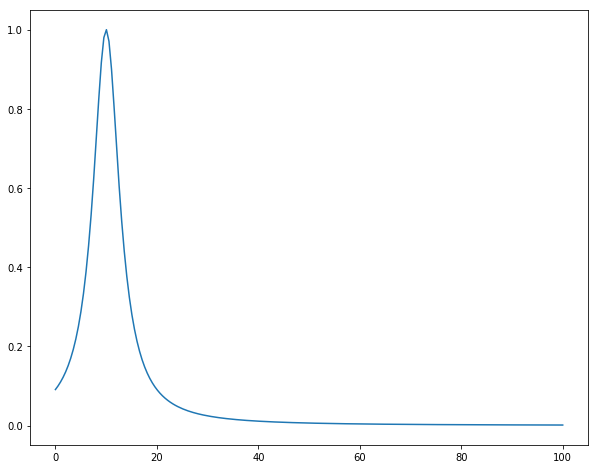

In [4]:
x = np.linspace(0,100,200)
mu = 23
L = 10.0
y = L / (L + (x - L)**2)
plt.plot(x,y)
plt.show()